# Jupyter Notebook for inter tissue WGCNA

## Load test dataset

In [2]:
tissues <- c("Adipose", "Muscle", "Brain")
expression_files <- c("/Users/edeneldar/CoExpression_ReProduction/old_outputs/AdipTest.csv",
                      "/Users/edeneldar/CoExpression_ReProduction/old_outputs/MuscleTest.csv",
                      "/Users/edeneldar/CoExpression_ReProduction/old_outputs/BrainTest.csv")

## Import libraries

In [1]:
library(WGCNA)
options(stringsAsFactors = FALSE)
suppressMessages(WGCNA::allowWGCNAThreads())

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: 'fastcluster'


The following object is masked from 'package:stats':

    hclust





Attaching package: 'WGCNA'


The following object is masked from 'package:stats':

    cor




Allowing multi-threading with up to 8 threads.


## Helper functions

- aggregate_by_donor - aggregate gene expression data by donor id (i.e. average expression of all samples from the same donor)

- split_gene_id - split gene id from tissue name (i.e. "FM_BA9_BA46_ENSG00000283992.12_PAR_Y" -> tissue: "FM_BA9_BA46", gene: "ENSG00000283992")

- make_CT_map - create map of tissues pairs and beta value for CT calculation with const beta value (i.e. for tissues = c("A", "B", "C") and beta = 2, the output will be a named vector with names: "A||B", "A||C", "B||C" and values: 2, 2, 2).

- require_or_stop - check that required R packages are installed and loadable, if any is missing, stop with an error message that include installation command.

- tissue_palette - Creates a named color palette for tissues using RColorBrewer's "Set1". It loads RColorBrewer, takes 8 distinct Set1 colors (skipping the 6th), and returns a named character vector of hex colors keyed by tissue names.

- split_pair - split tissue pair string "A||B" into a vector c("A", "B").

- ct_partner - given a tissue pair string "A||B" and one of the tissues (e.g., "A"), return the other tissue (e.g., "B").

- signed_R2_TS - Turns the scale free fit into "signed R²" for within-tissue (TS) fits.

- signed_R2_CT - Turns the scale free fit into "signed R²" for cross-tissue (CT) fits.

- LoadExprData - Reads a tissue-specific expression matrix from CSV, filters genes by variability, and standardizes column names (e.g., prefixing with tissue name). It returns a numeric matrix of samples x genes.

In [ ]:

.aggregate_by_donor <- function(mat) {
    d <- rownames(mat)
    split_idx <- split(seq_len(nrow(mat)), d)
    res <- do.call(rbind, lapply(split_idx, function(ix) {
        colMeans(mat[ix, , drop = FALSE], na.rm = TRUE)
    }))
    rownames(res) <- names(split_idx)
    storage.mode(res) <- "double"
    res
}
split_gene_id <- function(x) {
  x <- as.character(x)
  x <- sub("_PAR_Y$", "", x)
  tissue <- sub("_([^_]*)$", "", x)  
  gene   <- sub("^.*_", "", x)     
  list(tissue = tissue, gene = gene)
}
.make_CT_map <- function(tissues, beta) {
  if (length(tissues) < 2) return(setNames(numeric(0), character(0)))
  pairs <- t(combn(tissues, 2))
  keys  <- paste(pairs[,1], pairs[,2], sep = "||")
  setNames(rep.int(beta, length(keys)), keys)
}

.require_or_stop <- function(pkgs) {
  miss <- pkgs[!vapply(pkgs, requireNamespace, FUN.VALUE = TRUE, quietly = TRUE)]
  if (length(miss)) stop("Missing packages: ", paste(miss, collapse=", "),
                         "\nInstall: install.packages(c(", 
                         paste(sprintf('"%s"', miss), collapse=", "), "))")
}
.tissue_palette <- function(tissues) {
  .require_or_stop(c("RColorBrewer"))
  pal <- RColorBrewer::brewer.pal(9, "Set1")[c(1:5,7:9)]
  if (length(tissues) <= length(pal)) {
    setNames(pal[seq_along(tissues)], tissues)
  } else {
    setNames(rep(pal, length.out = length(tissues)), tissues)
  }
}

.split_pair <- function(x) strsplit(x, "\\|\\|", fixed = FALSE)

.ct_partner <- function(pair, t) {
  ab <- .split_pair(pair)[[1]]
  if (length(ab) != 2) return(NA_character_)
  if (identical(ab[1], t)) ab[2] else if (identical(ab[2], t)) ab[1] else NA_character_
}

.signed_R2_TS <- function(df) {
  slope_col <- if ("slope" %in% names(df)) "slope" else if ("slope.SFT" %in% names(df)) "slope.SFT" else NA
  if (is.na(slope_col)) return(df$SFT.R.sq)
  -sign(df[[slope_col]]) * df$SFT.R.sq
}

.signed_R2_CT <- function(df) {
  r2_col <- if ("Rsquared.SFT" %in% names(df)) "Rsquared.SFT" else if ("SFT.R.sq" %in% names(df)) "SFT.R.sq" else NA
  slope_col <- if ("slope.SFT" %in% names(df)) "slope.SFT" else if ("slope" %in% names(df)) "slope" else NA
  if (is.na(r2_col)) return(rep(NA_real_, nrow(df)))
  if (is.na(slope_col)) return(df[[r2_col]])
  -sign(df[[slope_col]]) * df[[r2_col]]
}

LoadExprData<-function(tissue_name, tissue_file_name, 
                       sd_quantile = 0.00,
                       max_genes_per_tissue = 5000
                       ) {
  
    if (grepl("\\.csv$", tissue_file_name)) {
        datExpr <- read.csv(tissue_file_name, check.names = FALSE)
        rownames(datExpr) <- datExpr[,1]
        datExpr <- as.matrix(datExpr[,-1,drop=FALSE])
    } else stop("Unsupported input file !!!")
  

    sds <- apply(datExpr, 2, sd, na.rm = TRUE)
    thr <- stats::quantile(sds, probs = sd_quantile, na.rm = TRUE)
    keep_sd <- sds >= thr
    datExpr <- datExpr[, keep_sd, drop = FALSE]
  
  
    if (ncol(datExpr) > max_genes_per_tissue) {
        o <- order(sds[colnames(datExpr)], decreasing = TRUE)
        datExpr <- datExpr[, o[seq_len(max_genes_per_tissue)], drop = FALSE]
    }
  
    colnames(datExpr) <- paste0(tissue_name, "_", colnames(datExpr))
    storage.mode(datExpr) <- "double"
    datExpr
}
  



In [3]:
adipose_expr <- as.matrix(read.csv(expression_files[1], row.names=1))
muscle_expr <- as.matrix(read.csv(expression_files[2], row.names=1))
brain_expr <- as.matrix(read.csv(expression_files[3], row.names=1))

In [11]:
split_idx <- split(seq_len(nrow(adipose_expr)), rownames(adipose_expr))
res <- do.call(rbind, lapply(split_idx, function(ix) {
        colMeans(adipose_expr[ix, , drop = FALSE], na.rm = TRUE)
    }))

In [13]:
x <- sub("_PAR_Y$", "", "ENSG00000283992.12_PAR_Y")

In [17]:
x <- "FM_BA9_BA46_ENSG00000283992.12_PAR_Y"
split_gene_id(x)

$tissue
[1] "FM_BA9_BA46"

$gene
[1] "ENSG00000283992.12"

In [19]:
pairs <- t(combn(tissues, 2))
keys  <- paste(pairs[,1], pairs[,2], sep = "||")
keys

[1] "Adipose||Muscle" "Adipose||Brain"  "Muscle||Brain"

In [21]:
setNames(rep.int(2, length(keys)), keys)

Adipose||Muscle  Adipose||Brain   Muscle||Brain 
              2               2               2

## Beta value selection

- checkScaleFree_logbin - get k, a vector of connectivity degrees for adj matrix, and evaluates how well the network’s degree sequence follows a scale-free (power-law) distribution. It log-bins the degrees k, fits a line to log10(P(k)) vs log10(k), and returns the power-law fit Rsquared.SFT and slope.SFT, plus an alternative truncated-exponential adjusted R² for comparison.
* lm1 - > $$log(P(k)) = a + b * log(k)$$
* lm2 - > $$log(P(k)) = a + b * log(k) + c * k$$
- checkScaleFree - get k, a vector of connectivity degrees for adj matrix, assesses how well the degree distribution follows a scale-free (power-law) distribution form using <b>linear binning(equal width bins)</b>. It partitions k into nBreaks bins equal ranges, computes each bin's mean degree dk and probability p.dk, then fits:
* lm1 - > $$log(P(k)) = a + b * log(k)$$
* lm2 - > $$log(P(k)) = a + b * log(k) + c * k$$

Note that checkScaleFree_logbin is the original function from WGCNA package, while checkScaleFree is a modified version that uses linear binning instead of log binning. We use the log binning version.

Also note that removeFirst parameter in checkScaleFree functions drops the first bin (the one with the lowest connectivity degrees) to reduce noise. Bins with missing values (NaN) are imputed with histogram mids.

- first_crossing_beta - Helper function for compute_crossings_from_fit_curves. Finds the smallest beta value that achieves a scale-free fit R² above a specified threshold (e.g., 0.8). Optionally, but recommended, also require that the slope of the fit is negative (indicating a decreasing trend in the degree distribution). This function iteratively tests increasing beta values, computes the adjacency matrix, calculates connectivity degrees, and evaluates the scale-free fit until the criteria are met or the maximum beta is reached (in the .compute_crossings_from_fit_curves function).

- compute_crossings_from_fit_curves - Given the beta-fit tables, find the first (smallest) beta value that cross an R² threshold (e.g., 0.8). It scans beta$TS_fit_curves (per tissue) and beta$CT_fit_curves (per tissue pair "A||B"), picks the earliest beta where R² exceeds the threshold, and optionally requires a negative slope. Returns a two named collections: TS (named by tissue) and CT (named by tissue pair "A||B").

- build_beta_matrix_from_crossings - Constructs a tissuextissue beta matrix from first crossing points of the scale-free fit curves. It calls .compute_crossings_from_fit_curves to get for each tissue, the first TS beta where R²>=threshold (and optionally slope<0), and for each tissue pair "A||B" the first CT beta. It then fills symmetric matrix B (rows/cols = tissues): the diagonal B[t, t] gets the TS crossing for tissue t, and each off-diagonal B[a,b] gets CT crossing for pair "a||b" (mirrored to B[b,a]). Entries without crossings are remain NA.



In [ ]:
checkScaleFree_logbin <- function(k, nBreaks = 10, removeFirst = FALSE) {
  kpos <- k[k > 0]                      
  br <- unique(10^seq(log10(min(kpos)), log10(max(kpos)), length.out = nBreaks + 1))
  h  <- hist(kpos, breaks = br, plot = FALSE, right = TRUE)

  dk   <- h$mids                        
  p.dk <- h$counts / sum(h$counts)

  log.dk  <- log10(dk)
  if (removeFirst) { log.dk <- log.dk[-1]; p.dk <- p.dk[-1] }
  log.p   <- log10(p.dk + 1e-9)

  lm1 <- lm(log.p ~ log.dk)
  lm2 <- lm(log.p ~ log.dk + I(10^log.dk)) 

  data.frame(
    Rsquared.SFT = summary(lm1)$r.squared,
    slope.SFT    = coef(lm1)[2],
    truncatedExponentialAdjRsquared = summary(lm2)$adj.r.squared
  )
}


checkScaleFree <- function (k, nBreaks = 10, removeFirst = FALSE) 
{
  discretized.k = cut(k, nBreaks)
  dk = tapply(k, discretized.k, mean)
  p.dk = as.vector(tapply(k, discretized.k, length)/length(k))
  breaks1 = seq(from = min(k), to = max(k), length = nBreaks + 1)
  hist1 = hist(k, breaks = breaks1, plot = FALSE, right = TRUE)
  dk2 = hist1$mids
  dk = ifelse(is.na(dk), dk2, dk)
  dk = ifelse(dk == 0, dk2, dk)
  p.dk = ifelse(is.na(p.dk), 0, p.dk)
  log.dk = as.vector(log10(dk))
  if (removeFirst) {
    p.dk = p.dk[-1]
    log.dk = log.dk[-1]
  }
  log.p.dk = as.numeric(log10(p.dk + 1e-09))
  lm1 = lm(log.p.dk ~ log.dk)
  lm2 = lm(log.p.dk ~ log.dk + I(10^log.dk))
  datout = data.frame(Rsquared.SFT = summary(lm1)$r.squared, slope.SFT = summary(lm1)$coefficients[2, 1], truncatedExponentialAdjRsquared = summary(lm2)$adj.r.squared)
  datout
}

.get_col <- function(df, candidates) {
  for (nm in candidates) if (nm %in% names(df)) return(nm)
  NA_character_
}


.first_crossing_beta <- function(df, thr = 0.80, require_nonpos_slope = TRUE) {
  if (!nrow(df)) return(NA_integer_)
  r2_col    <- .get_col(df, c("SFT.R.sq", "Rsquared.SFT"))
  slope_col <- .get_col(df, c("slope", "slope.SFT"))
  if (is.na(r2_col)) return(NA_integer_)
  df <- df[order(df$Power), , drop = FALSE]
  ok <- is.finite(df[[r2_col]]) & df[[r2_col]] >= thr
  if (require_nonpos_slope && !is.na(slope_col)) {
    ok <- ok & is.finite(df[[slope_col]]) & (df[[slope_col]] <= 0)
  }
  idx <- which(ok)
  if (length(idx)) as.integer(df$Power[idx[1]]) else NA_integer_
}

.compute_crossings_from_fit_curves <- function(beta_info, tissues, thr = 0.80, require_nonpos_slope = TRUE) {
  ts_df <- beta_info$TS_fit_curves
  ct_df <- beta_info$CT_fit_curves

  TS_cross <- setNames(rep(NA_integer_, length(tissues)), tissues)
  if (!is.null(ts_df) && nrow(ts_df)) {
    for (t in tissues) {
      cols <- c("Power",
          .get_col(ts_df, c("SFT.R.sq","Rsquared.SFT")),
                .get_col(ts_df, c("slope","slope.SFT")))
      cols <- cols[!is.na(cols) & cols %in% names(ts_df)]
      sub  <- ts_df[ts_df$tissue == t, cols, drop = FALSE]
      TS_cross[t] <- .first_crossing_beta(sub, thr = thr, require_nonpos_slope = require_nonpos_slope)
    }
  }

  CT_cross <- numeric(0)
  if (!is.null(ct_df) && nrow(ct_df)) {
    pairs <- unique(ct_df$pair)
    for (pr in pairs) {
      cols <- c("Power",
          .get_col(ct_df, c("Rsquared.SFT","SFT.R.sq")),
          .get_col(ct_df, c("slope.SFT","slope")))
      cols <- cols[!is.na(cols) & cols %in% names(ct_df)]
      sub  <- ct_df[ct_df$pair == pr, cols, drop = FALSE]
      CT_cross[pr] <- .first_crossing_beta(sub, thr = thr, require_nonpos_slope = require_nonpos_slope)
    }
  }
  list(TS = TS_cross, CT = CT_cross)
}
build_beta_matrix_from_crossings <- function(beta_info, tissues, thr = 0.80, require_nonpos_slope = TRUE) {
  crosses <- .compute_crossings_from_fit_curves(beta_info, tissues, thr, require_nonpos_slope)
  B <- matrix(NA_real_, nrow = length(tissues), ncol = length(tissues),
              dimnames = list(tissues, tissues))

  # diag from TS crossings
  for (t in tissues) B[t, t] <- crosses$TS[[t]]

  # off-diagonals from CT crossings
  if (!is.null(crosses$CT) && length(crosses$CT)) {
    for (nm in names(crosses$CT)) {
      ab <- strsplit(nm, "\\|\\|")[[1]]
      if (length(ab) != 2) next
      a <- ab[1]; b <- ab[2]
      if (a %in% tissues && b %in% tissues) {
        B[a, b] <- crosses$CT[[nm]]
        B[b, a] <- crosses$CT[[nm]]
      }
    }
  }
  B
}

In [29]:
set.seed(1)
A <- matrix(runif(100, 0, 1), 10, 10); diag(A) <- 0   # toy adjacency
k <- rowSums(A)   # connectivity degrees
nBreaks <- 5
removeFirst <- FALSE

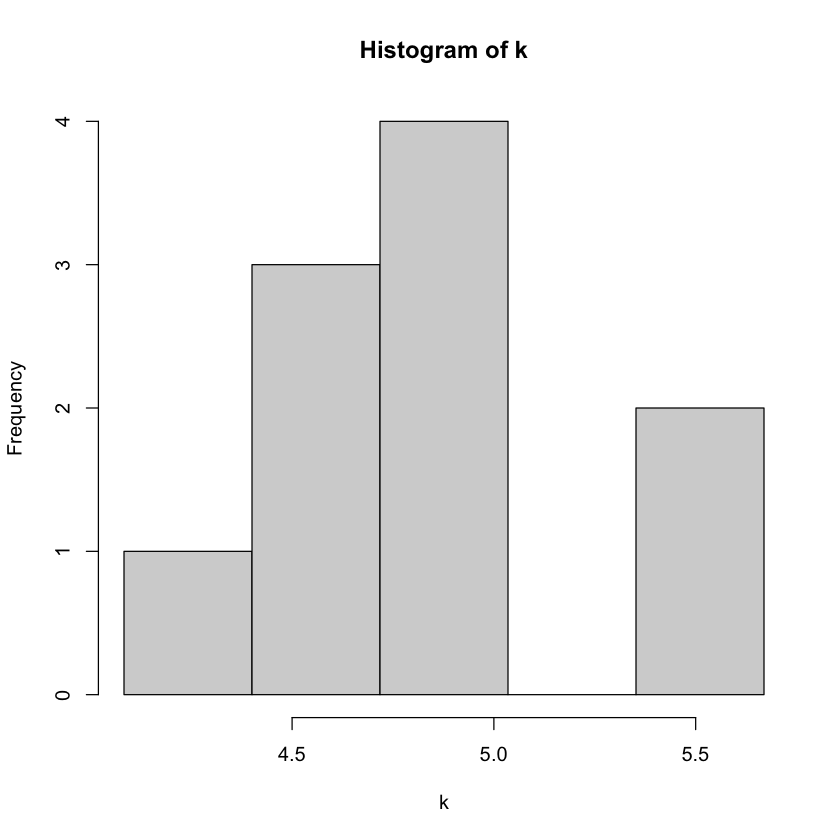

In [31]:
# build an histogram of the connectivity degrees with linear bins
discretized.k = cut(k, nBreaks)
dk = tapply(k, discretized.k, mean)
p.dk = as.vector(tapply(k, discretized.k, length)/length(k))
breaks1 = seq(from = min(k), to = max(k), length = nBreaks + 1)
hist1 = hist(k, breaks = breaks1, plot = TRUE,
             right = TRUE)

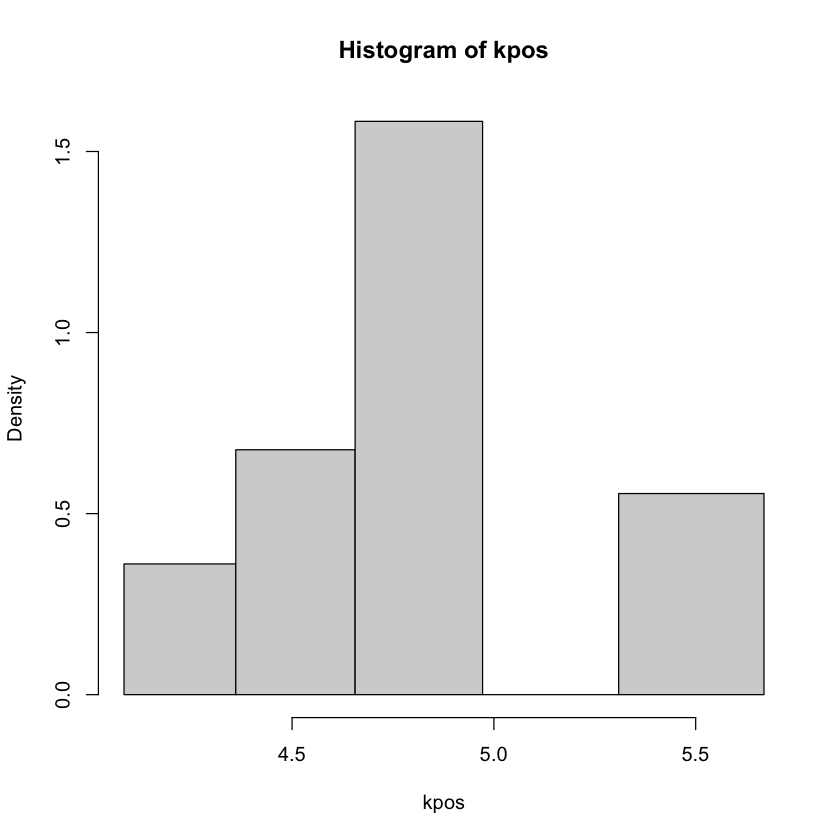

In [ ]:
kpos <- k[k > 0]
br <- unique(10^seq(log10(min(kpos)), log10(max(kpos)), length.out = nBreaks + 1))
h  <- hist(kpos, breaks = br, plot = TRUE, right = TRUE)

In [32]:
dk  <- h$mids
p.dk <- h$counts / sum(h$counts)

log.dk <- log10(dk)
if (removeFirst) { log.dk <- log.dk[-1]; p.dk <- p.dk[-1]}
log.p   <- log10(p.dk + 1e-9)

In [33]:
lm1 <- lm(log.p ~ log.dk)
lm2 <- lm(log.p ~ log.dk + I(10^log.dk))

In [34]:
summary(lm1)


Call:
lm(formula = log.p ~ log.dk)

Residuals:
      1       2       3       4       5 
-0.2000  0.8709  2.0388 -5.8903  3.1806 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)    16.10      30.90   0.521    0.638
log.dk        -27.01      45.19  -0.598    0.592

Residual standard error: 4.073 on 3 degrees of freedom
Multiple R-squared:  0.1064,	Adjusted R-squared:  -0.1914 
F-statistic: 0.3573 on 1 and 3 DF,  p-value: 0.5921


In [35]:
summary(lm2)


Call:
lm(formula = log.p ~ log.dk + I(10^log.dk))

Residuals:
     1      2      3      4      5 
-1.236  1.368  3.088 -5.338  2.117 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)    155.07     340.93   0.455    0.694
log.dk        -588.71    1371.18  -0.429    0.709
I(10^log.dk)    50.55     123.30   0.410    0.722

Residual standard error: 4.791 on 2 degrees of freedom
Multiple R-squared:  0.1757,	Adjusted R-squared:  -0.6486 
F-statistic: 0.2131 on 2 and 2 DF,  p-value: 0.8243


## STARNET-style soft-thresholding search

- pickSoftThreshold_withinTissue - For a sngle tissue expression matrix (samples x genes), evaluates how well the network becomes scale-free across a grid of soft-threshold powers. For each candidate beta in powerVector, it computes the correlation matrix, applies unsigned, builds adjacency $A=|r|^beta$, with zero diagonal, derives node degrees, and uses log-binned scale free fitting (checkScaleFree_logbin) to record SFT.R.sq, slope, and degree summaries (mean.k, median.k, max.k). Returns a list(fitIndices=<data.frame>).

- first_bin_mass - Returns the proportion of degrees that fall into the first equal-width histogram bin. This helps assess if the network has many low-degree nodes, which can affect scale-free fitting. It builds nBreaks+1 linear cut points over [min(k), max(k)], and computes the share of k in the lowest bin. Useful to detect a heavy small-degree pile-up that can bias scale-free fitting.


In [ ]:

.cor_mat_TS <- function(X, cor_method) {
  cor(X, use = "pairwise.complete.obs", method = cor_method)
}

.cor_mat_CT <- function(Mi, Mj, cor_method) {
  cor(Mi, Mj, use = "pairwise.complete.obs", method = cor_method)
}

pickSoftThreshold_withinTissue <- function(
  expr,                        
  powerVector = c(1:10, seq(12, 20, 2)),
  cor_method  = "pearson",
  unsigned    = TRUE,        
  nBreaks     = 10,
  removeFirst = FALSE,
  use_signed_R2 = FALSE       
){
  S <- .cor_mat_TS(expr, cor_method)
  if (unsigned) S <- abs(S)

  fit_df <- data.frame(
    Power    = powerVector,
    SFT.R.sq = NA_real_,
    slope    = NA_real_,
    mean.k   = NA_real_,
    median.k = NA_real_,
    max.k    = NA_real_,
    stringsAsFactors = FALSE
  )

  for (ix in seq_along(powerVector)) {
    b <- powerVector[ix]
    B <- S ^ b
    diag(B) <- 0                    
    k <- rowSums(B)                

    cf <- checkScaleFree_logbin(k, nBreaks = nBreaks, removeFirst = removeFirst)
    r2    <- cf$Rsquared.SFT[1]
    slope <- cf$slope.SFT[1]

    fit_df$slope[ix]    <- slope
    fit_df$SFT.R.sq[ix] <- if (use_signed_R2) sign(slope) * r2 else r2
    fit_df$mean.k[ix]   <- mean(k)
    fit_df$median.k[ix] <- stats::median(k)
    fit_df$max.k[ix]    <- max(k)
  }
  list(fitIndices = fit_df)
}
.first_bin_mass <- function(k, nBreaks) {
  br <- seq(min(k, na.rm=TRUE), max(k, na.rm=TRUE), length.out = nBreaks + 1L)
  if (!is.finite(br[1]) || !is.finite(br[2])) return(0)
  mean(k >= br[1] & k <= br[2], na.rm = TRUE)
}
pickSoftThreshold_crossTissue <- function(
  Mi, Mj,                       
  powerVector = c(1:10, seq(12, 20, 2)),
  cor_method  = "pearson",
  unsigned    = TRUE,
  nBreaks     = 10,
  removeFirst = TRUE,
  use_signed_R2 = FALSE,
  fisher       = FALSE,
  fisher_scheme= c("to_ref","lambda"),
  fisher_Nref  = c("median","max"),
  fisher_cap   = TRUE,
  fisher_lambda= 10,
  min_common   = 3L
){
  fisher_scheme <- match.arg(fisher_scheme)
  stopifnot(nrow(Mi) == nrow(Mj))
  
  S <- if (fisher) {
    fisherZ_shrink_bipartite(
      Mi, Mj, cor_method = cor_method,
      scheme = fisher_scheme, N_ref = fisher_Nref,
      min_n = min_common, cap_at_1 = fisher_cap, lambda = fisher_lambda
    )
  } else {
    .cor_mat_CT(Mi, Mj, cor_method)
  }
  if (unsigned) S <- abs(S)

  fit_df <- data.frame(Power=powerVector, SFT.R.sq=NA_real_, slope=NA_real_,
                       mean.k=NA_real_, median.k=NA_real_, max.k=NA_real_,
                       stringsAsFactors = FALSE)
  for (ix in seq_along(powerVector)) {
    b <- powerVector[ix]
    B <- S ^ b
    k <- c(rowSums(B), colSums(B))
    cf <- checkScaleFree_logbin(k, nBreaks = nBreaks, removeFirst = removeFirst)
    fit_df$slope[ix]    <- cf$slope.SFT[1]
    fit_df$SFT.R.sq[ix] <- if (use_signed_R2) sign(cf$slope.SFT[1]) * cf$Rsquared.SFT[1] else cf$Rsquared.SFT[1]
    fit_df$mean.k[ix]   <- mean(k); fit_df$median.k[ix] <- stats::median(k); fit_df$max.k[ix] <- max(k)
  }
  list(fitIndices = fit_df)
}

# =============================== auto_pick_powers ===============================
.choose_power_from_pickSoft <- function(sft, targetR2 = 0.80) {
  df <- sft$fitIndices
  ok <- which(df$SFT.R.sq >= targetR2 & df$slope < 0)
  if (length(ok) > 0) {
    return(min(df$Power[ok]))
  } else {
    return(df$Power[which.max(df$SFT.R.sq)])
  }
}

auto_pick_powers <- function(
  tissue_names,
  tissue_expr_file_names,
  sd_quantile = 0.90,
  max_genes_per_tissue = 4000,
  cor_method = "pearson",                
  beta_grid = c(1:10, seq(12, 20, 2)),
  targetR2 = 0.80,
  unsigned        = TRUE,
  nBreaks         = 10,
  removeFirst     = TRUE,
  use_signed_R2_TS = FALSE,
  use_signed_R2_CT = FALSE,
  ct_fisher = FALSE,
  ct_fisher_scheme = "to_ref",
  ct_fisher_Nref = "median",
  ct_fisher_cap_at_1 = TRUE,
  ct_fisher_lambda = 10,
  ct_min_common = 3L
){
  stopifnot(length(tissue_names) == length(tissue_expr_file_names))
  T <- length(tissue_names)

  expr_list   <- vector("list", T)
  donors_list <- vector("list", T)
  for (i in seq_len(T)) {
    X <- LoadExprData(
      tissue_name      = tissue_names[i],
      tissue_file_name = tissue_expr_file_names[i],
      sd_quantile      = sd_quantile,
      max_genes_per_tissue = max_genes_per_tissue
    )
    expr_list[[i]]   <- X
    donors_list[[i]] <- .aggregate_by_donor(X)
  }

  TS_per_tissue <- integer(T)
  TS_fit_curves <- vector("list", T)

  TS_power_map <- setNames(integer(T), tissue_names)
  for (i in seq_len(T)) {
    sft_ts <- tryCatch(
      pickSoftThreshold_withinTissue(
        expr            = expr_list[[i]],
        powerVector     = beta_grid,
        cor_method      = cor_method,
        unsigned        = unsigned,
        nBreaks         = nBreaks,
        removeFirst     = removeFirst,
        use_signed_R2   = use_signed_R2_TS
      ),
      error = function(e) { message("[TS beta pick] ", tissue_names[i], " error: ", e$message); NULL }
    )
    if (!is.null(sft_ts)) {
      fi <- sft_ts$fitIndices
      fi$tissue <- tissue_names[i]
      TS_fit_curves[[i]] <- fi
      TS_per_tissue[i] <- .choose_power_from_pickSoft(sft_ts, targetR2 = targetR2)
      TS_power_map[tissue_names[i]] <- TS_per_tissue[i]
    } else {
      TS_fit_curves[[i]] <- data.frame(Power = beta_grid,
                                       SFT.R.sq = NA_real_,
                                       slope = NA_real_,
                                       mean.k = NA_real_,
                                       median.k = NA_real_,
                                       max.k = NA_real_,
                                       tissue = tissue_names[i])
      TS_per_tissue[i] <- 6L
    }
  }
  TS_fit_curves_df <- do.call(rbind, TS_fit_curves)
  TS_power <- as.integer(stats::median(TS_per_tissue, na.rm = TRUE))

  CT_betas    <- integer(0)
  CT_fit_list <- list()

  CT_power_map <- numeric(0)
  if (T >= 2) {
    for (i in 1:(T - 1)) {
      for (j in (i + 1):T) {
        di <- rownames(donors_list[[i]]); dj <- rownames(donors_list[[j]])
        common <- intersect(di, dj)
        pair_id <- paste(tissue_names[i], tissue_names[j], sep = "||")

        if (length(common) < 3) {
          message(sprintf("[CT beta pick] %s: |common donors|=%s → skip", pair_id, length(common)))
          next
        }
        Mi <- donors_list[[i]][common, , drop = FALSE]
        Mj <- donors_list[[j]][common, , drop = FALSE]

        sft_ct <- tryCatch(
          pickSoftThreshold_crossTissue(
            Mi, Mj,
            powerVector   = beta_grid,
            cor_method    = cor_method,
            unsigned      = unsigned,
            nBreaks       = nBreaks,
            removeFirst   = removeFirst,
            use_signed_R2 = use_signed_R2_CT,
            fisher        = ct_fisher,                
            fisher_scheme = ct_fisher_scheme,
            fisher_Nref   = ct_fisher_Nref,
            fisher_cap    = ct_fisher_cap_at_1,
            fisher_lambda = ct_fisher_lambda,
            min_common    = ct_min_common
          ),
          error = function(e) { message("[CT beta pick] ", pair_id, " error: ", e$message); NULL }
        )


        if (!is.null(sft_ct)) {
          best_beta <- .choose_power_from_pickSoft(sft_ct, targetR2 = targetR2)
          CT_betas <- c(CT_betas, best_beta)
          CT_power_map[pair_id] <- best_beta
          message(sprintf("[CT beta pick] %s: beta=%s", pair_id, best_beta))

          fi <- sft_ct$fitIndices
          CT_fit_list[[length(CT_fit_list) + 1]] <- data.frame(
            pair = pair_id,
            Power = fi$Power,
            Rsquared.SFT = fi$SFT.R.sq,
            stringsAsFactors = FALSE
          )
        } else {
          CT_fit_list[[length(CT_fit_list) + 1]] <-
            data.frame(pair = pair_id, Power = beta_grid, Rsquared.SFT = NA_real_)
        }
      }
    }
  }

  CT_power <- if (length(CT_betas) == 0) {
    message("[CT beta pick] no valid CT pairs → CT_power=3 (fallback)")
    3L
  } else {
    as.integer(stats::median(CT_betas, na.rm = TRUE))
  }

  CT_fit_curves_df <- if (length(CT_fit_list)) do.call(rbind, CT_fit_list) else
    data.frame(pair = character(), Power = integer(), Rsquared.SFT = numeric())

  list(
    TS_power       = TS_power,
    CT_power       = CT_power,
    TS_per_tissue  = TS_per_tissue,
    CT_per_pair    = CT_betas,
    TS_fit_curves  = TS_fit_curves_df,
    CT_fit_curves  = CT_fit_curves_df,
    TS_power_map   = TS_power_map,
    CT_power_map   = CT_power_map
  )
}


## Core WGCNA functions

- AdjacencyFromExpr - Builds a block-structured gene-gene adjacency matrix from per tissue expression files.
* <b>Process:</b>
 1. Load each tissue via LoadExprData, and creates a donor-averaged version for cross-tissue use.
 2. Within-tissue (TS) blocks: computes $S_{ii} = |cor(X_i)|$ and raises to power β (tissue-specific) $A_{ii} = S_{ii}^β$.
 3. Cross-tissue (CT) blocks: intersects donors, computes $S_{ij} = |cor(M_{i}, M_{j})|$ (or shrunk via fisherZ_shrink_bipartite), then $A_{ij} = S_{ij}^β$ (tissue-pair specific) and mirrors to $A_{ji}$. If shared donors < ct_min_common, either stop or fill that blocks with zeros.
 4. Concatenates all blocks into a single symmetric adjacency matrix (genesxgenes), writes to .rds file, and returns it.

 - Cross_Tissue_TOM - Computes the Topological Overlap Matrix (TOM) from a weighted gene-gene adjacency, using block processing to save memory.
 Given an adjacency A (genes x genes, typically with diag(A)=0 and values in [0,1]), it first computes node degrees $k_i = \sum_j{A_{ij}}$. 
 For each block pair it forms $num = A_{iu}A_{ju}^T$ (shared neighbor strength), takes the submatrix #A_{ij}$, and outputs $$ TOM_{ij} = \frac{num + A_{ij}}{min(k_i, k_j) + 1 - A_{ij}} $$

 writing the symmetric result into the full nxn matrix (with original dimnames). It returns the TOM matrix.

 - Clusters_Table - Identifies gene modules from a TOM matrix and returns a compact membership table. Also, saves a TOM heatmap. It computes hierarchical clustering on 1-TOM (with average linkage), cuts the tree with dynamicTreeCut (deepSplit=TRUE, minClusterSize), drops the grey (unassigned) genes, plots a network heatmap (TOMplot) to TOM_heatmap_WGCNA_<group>.png, and builds a 3-column matrix:
 * <b>Cluster ID</b> - sequential module index by size (1=largest, 1..K, excluding grey)
 * <b>Tissue</b> - parsed from <TISSUE>_<GENEID> column names
 * <b>Gene Symbol</b> - parsed gene name

- Clusters_Details - Summarizes each module's composition across tissues and labels it TS vs CT.
Given clusters_table (with columns Cluster ID, Tissue, Gene Symbol), it:
    1. Normalizes column names and infers the unique tissue set.
    2. For each cluster, computes size, per-tissue counts and proportions, dominant tissue and a label:
       - "TS" if the maximum tissue proportion >= cluster_type_thr (default 0.95), otherwise "CT".
    3. Returns a numeric/character matrix with columns:
       - Cluster ID
       - Cluster Size
       - Cluster Type (TS/CT)
       - Cluster Tissues (comma-separated)
       - one column per tissue with gene counts
       - Dominant Tissue

In [ ]:

AdjacencyFromExpr <- function(
    tissue_names = NULL,
    tissue_expr_file_names = NULL,
    sd_quantile = 0.00,
    max_genes_per_tissue = 5000,
    cor_method = "pearson",
    TS_power_map = NULL,
    CT_power_map = NULL,
    default_TS = 6L,
    default_CT = 3L,
    ct_fisher = FALSE,
    ct_fisher_scheme   = c("to_ref","lambda"),
    ct_fisher_Nref     = c("median","max"), 
    ct_fisher_cap_at_1 = TRUE,
    ct_fisher_lambda   = 10,
    ct_min_common      = 3L,
    ct_too_few_action  = c("stop","zeros")
) {
  ct_fisher_scheme  <- match.arg(ct_fisher_scheme)
  ct_too_few_action <- match.arg(ct_too_few_action)
  stopifnot(length(tissue_names) == length(tissue_expr_file_names))
  T <- length(tissue_names)
  
  expr_list   <- vector("list", T)
  donor_mat <- vector("list", T)
  idx <- integer(T+1); rc_names <- character(0)

  
  for (i in seq_len(T)) {
    X <- LoadExprData(
      tissue_names[i], tissue_expr_file_names[i],
      sd_quantile = sd_quantile,
      max_genes_per_tissue = max_genes_per_tissue
    )
    expr_list[[i]] <- X
    donor_mat[[i]] <- .aggregate_by_donor(X)
    idx[i + 1] <- idx[i] + ncol(X)
    rc_names <- c(rc_names, colnames(X))
  }
  
  A <- matrix(0, nrow = idx[T + 1],
                    ncol = idx[T + 1],
                    dimnames = list(rc_names, rc_names))
  
  for (i in 1:T) {
    rows <- (idx[i] + 1):idx[i + 1]
    pow_i <- if(!is.null(TS_power_map) && !is.na(TS_power_map[tissue_names[i]])) {
      as.integer(TS_power_map[tissue_names[i]])
    } else {
      default_TS
    }
    Sii <- abs(cor(
      expr_list[[i]], use = "pairwise.complete.obs", method = cor_method
    ))
    A[rows, rows] <- Sii^pow_i
  }
  
  if (T >= 2) {
    for (i in 1:(T - 1)) {
      rows <- (idx[i] + 1):idx[i + 1]
      di <- rownames(donor_mat[[i]])
      for (j in (i + 1):T) {
        cols <- (idx[j] + 1):idx[j + 1]
        pair_ij <- paste(tissue_names[i], tissue_names[j], sep = "||")
        pair_ji <- paste(tissue_names[j], tissue_names[i], sep = "||")
        pow_ij <- if(!is.null(CT_power_map)) {
          if(!is.na(CT_power_map[pair_ij])){
            as.integer(CT_power_map[pair_ij])
          } else if(!is.na(CT_power_map[pair_ji])){
            as.integer(CT_power_map[pair_ji])
          } else default_CT
        } else default_CT

        dj <- rownames(donor_mat[[j]])
        common <- intersect(di, dj)

        if (length(common) < ct_min_common) {
          msg <- sprintf("Too few common donors between %s and %s (|common|=%f).",
                         tissue_names[i], tissue_names[j], length(common))
          if (ct_too_few_action == "stop") stop(msg)
          next
        }

        Mi <- donor_mat[[i]][common, , drop = FALSE]
        Mj <- donor_mat[[j]][common, , drop = FALSE]

        if (ct_fisher) {
          Sij <- fisherZ_shrink_bipartite(
            Mi, Mj,
            cor_method = cor_method,
            scheme     = ct_fisher_scheme,
            N_ref      = ct_fisher_Nref,
            min_n      = ct_min_common,
            cap_at_1   = ct_fisher_cap_at_1,
            lambda     = ct_fisher_lambda
          )
        } else {
          Sij <- stats::cor(Mi, Mj, use = "pairwise.complete.obs", method = cor_method)
          Sij[!is.finite(Sij)] <- 0
        }

        C <- abs(Sij) ^ pow_ij
        A[rows, cols] <- C
        A[cols, rows] <- t(C)
      }
    }
  }


  saveRDS(A, "adj_mat.rds")
  A
}




Cross_Tissue_TOM <- function(adj_mat, block_size = 2000L) {
    message("Computing TOM from adjacency matrix...")
    n <- nrow(adj_mat)
    rn <- rownames(adj_mat)
    cn <- colnames(adj_mat)
    k <- rowSums(adj_mat)
    message("Number of genes: ", n, "; Number of samples: ", ncol(adj_mat))
    TOM_mat <- matrix(0, n, n)
    for (i in seq(1, n, by = block_size)){
        message("Processing block ", i, " to ", min(i + block_size - 1, n))
        i2 <- min(i + block_size - 1, n)
        Ai <- adj_mat[i:i2, , drop = FALSE]
        ki <- k[i:i2]

        for (j in seq(i, n, by = block_size)){
            j2 <- min(j + block_size - 1, n)
            Aj <- adj_mat[j:j2, , drop = FALSE]
            kj <- k[j:j2]

            num <- Ai %*% t(Aj)
            Aij <- adj_mat[i:i2, j:j2, drop = FALSE]
            denom <- outer(ki, kj, pmin) + 1 - Aij

            block <- (Aij + num) / denom
            TOM_mat[i:i2, j:j2] <- block
            if (j > i) TOM_mat[j:j2, i:i2] <- t(block)
            rm(Aj, num, Aij, denom, block)
            gc(FALSE)
        }
        message("Finished block ", i, " to ", i2)
        rm(Ai)
        gc(FALSE)
    }
    dimnames(TOM_mat) <- list(rn, cn)
    message("TOM calculation done.")
    TOM_mat
}


Clusters_Table <- function(TOM_mat, minClusterSize = 30, plot_heatmap = FALSE, tissue_names, tissue_expr_file_names, group) {
    library(dynamicTreeCut)

    gene_names <- colnames(TOM_mat)
    if (is.null(gene_names)) gene_names <- rownames(TOM_mat)

    dist_TOM_mat <- 1 - TOM_mat

    h_TOM <- hclust(as.dist(dist_TOM_mat), method = "average")

    sizeGrWindow(12, 9)
    plot(h_TOM, xlab = "", sub = "", main = "Gene clustering on TOM-based dissimilarity", 
    labels = FALSE, hang = 0.04)

    dynamicMods <- cutreeDynamic(h_TOM, method = "tree", deepSplit = TRUE, 
                                minClusterSize = minClusterSize)
    dynamicColors <- labels2colors(dynamicMods)
    
    restGenes <- (dynamicColors != "grey")
    message("Plot heatmap", sum(restGenes))


    network_heatmap_WGCNA(
      TOM_mat = TOM_mat,
      dynamicColors = dynamicColors,
      restGenes = restGenes,
      out_file = paste0("TOM_heatmap_WGCNA_", group, ".png"),
      tom_power = 1
    )

    module_labels <- sort(setdiff(unique(as.integer(dynamicMods)), 0L))
    if (length(module_labels) == 0L) {
        warning("No non-grey modules detected.")
        empty <- matrix(nrow = 0, ncol = 3)
        colnames(empty) <- c("Cluster ID", "Tissue", "Gene Symbol")
        return(empty)
    }

    sp <- split_gene_id(gene_names)
    tissue_vec <- sp$tissue
    gene_vec   <- sp$gene

    df_list <- vector("list", length(module_labels))
    for (k in seq_along(module_labels)) {
        lab <- module_labels[k]
        idx <- which(dynamicMods == lab)
        if (length(idx) == 0L) next

        df_list[[k]] <- data.frame(
            "Cluster ID" = rep.int(k, length(idx)),
            "Tissue" = tissue_vec[idx],
            "Gene Symbol" = gene_vec[idx],
            stringAsFactors = FALSE,
            check.names = FALSE
        )
    }

    cluster_table <- do.call(rbind, Filter(Negate(is.null), df_list))
    cluster_table <- as.matrix(cluster_table)
    return(cluster_table)
}

Clusters_Details <- function(clusters_table, cluster_type_thr = 0.95) {
  if (is.null(clusters_table) || nrow(clusters_table) == 0) {
    warning("clusters_table is empty; returning empty details.")
    return(matrix(nrow = 0, ncol = 0))
  }
  
  cn <- colnames(clusters_table)
  colnames(clusters_table) <- sub("\\.", " ", cn)
  
  required <- c("Cluster ID", "Tissue", "Gene Symbol")
  missing  <- setdiff(required, colnames(clusters_table))
  if (length(missing) > 0) {
    stop("clusters_table missing columns: ", paste(missing, collapse = ", "))
  }
  
  tissue_names   <- names(table(clusters_table[, "Tissue"]))
  total_clusters <- max(as.numeric(clusters_table[, "Cluster ID"]))
  
  clusters_table_details <- matrix(0, nrow = total_clusters, ncol = (5 + length(tissue_names)))
  colnames(clusters_table_details) <- c('Cluster ID', 'Cluster Size', 'Cluster Type',
                                        'Cluster Tissues', tissue_names, 'Dominant Tissue')
  
  for (i in 1:total_clusters) {
    temp_cluster <- clusters_table[as.numeric(clusters_table[, "Cluster ID"]) == i, , drop = FALSE]
    
    clusters_table_details[i, "Cluster ID"]   <- i
    clusters_table_details[i, "Cluster Size"] <- nrow(temp_cluster)
    
    if (nrow(temp_cluster) == 0) {
      clusters_table_details[i, "Cluster Type"] <- 'NA'
      next
    }
    
    prop_tbl <- round(table(temp_cluster[, "Tissue"]) / nrow(temp_cluster), 2)
    clusters_table_details[i, "Cluster Type"] <- ifelse(max(prop_tbl) >= cluster_type_thr, 'TS', 'CT')
    
    clusters_table_details[i, "Cluster Tissues"] <- paste(names(table(temp_cluster[, "Tissue"])), collapse = ',')
    clusters_table_details[i, names(table(temp_cluster[, "Tissue"]))] <- table(temp_cluster[, "Tissue"])
    clusters_table_details[i, "Dominant Tissue"] <- names(which.max(table(temp_cluster[, "Tissue"])))
  }
  
  clusters_table_details
}



## Fisher Z transformation

- fisherZ_shrink_bipartite - Computes cross-tissue (bipartite) gene-gene correlations with variance shrinkage based on the number of shared donors. Given donorxgene matrices Mi and Mj, it calculates pearson correlations, applies Fisher Z transformation, shrinks the Z values by sample overlap (either to a reference N or with a lambda parameter), back transforms to correlations, and sets pairs with too few donors (min_n) to 0. This stabilizes CT edges when donor overlap is low and prevents inflated correlations from small overlaps sizes.

* scheme = "to_ref" scales by $$\sqrt{\frac{(n-3)}{(N_ref-3)}}$$ with optional capping. scheme = "lambda" use weight $$w = \frac{(n-3)}{(n-3+\lambda)}$$ for shrinkage.

In [ ]:

fisherZ_shrink_bipartite <- function(
  Mi, Mj,
  cor_method = "pearson",
  scheme     = c("to_ref","lambda"),
  N_ref      = c("median","max"),  
  min_n      = 3L,
  cap_at_1   = TRUE,               
  lambda     = 10,                 
  eps        = 1e-7
){
  scheme <- match.arg(scheme)
  Ri <- is.finite(as.matrix(Mi)); Rj <- is.finite(as.matrix(Mj))
  n_mat <- t(Ri) %*% Rj

  if (tolower(cor_method) == "bicor") {
    S <- WGCNA::bicor(Mi, Mj, use = "pairwise.complete.obs", maxPOutliers = 1)
  } else {
    S <- stats::cor(Mi, Mj, use = "pairwise.complete.obs", method = "pearson")
  }
  S[!is.finite(S)] <- 0
  S <- pmax(pmin(S, 1 - eps), -1 + eps)  

  Z <- atanh(S)                           
  n_ok <- n_mat >= min_n

  if (scheme == "to_ref") {
    if (length(N_ref) == 1 && is.character(N_ref)) {
      nn <- as.vector(n_mat[n_ok])
      if (!length(nn)) return(matrix(0, nrow = ncol(Mi), ncol = ncol(Mj),
                                     dimnames = list(colnames(Mi), colnames(Mj))))
      N0 <- if (N_ref[1] == "max") max(nn) else stats::median(nn)
      N0 <- max(as.integer(round(N0)), min_n + 1L)
    } else {
      N0 <- max(as.integer(N_ref[1]), min_n + 1L)
    }
    fac <- sqrt(pmax(n_mat - 3, 0) / pmax(N0 - 3, 1))
    if (cap_at_1) fac <- pmin(fac, 1)
    Zadj <- Z * fac
  } else {
    w <- pmax(n_mat - 3, 0) / (pmax(n_mat - 3, 0) + lambda)
    Zadj <- Z * w
  }

  R <- tanh(Zadj)
  R[!n_ok] <- 0                         
  R[!is.finite(R)] <- 0
  dimnames(R) <- list(colnames(Mi), colnames(Mj))
  R
}

## visualizations
- plot_beta_series_pdf - draws a multi-page PDF of scale-free fit curves (R² vs beta) per tissue, with cross-tissue overlays and the first crossing points marked. For each tissue, it plots the TS curve in black and all CT partners curves in distinct colors, adds a horizontal line at the R² threshold, and dashed vertical lines at the first crossing beta values where beta >=threshold (if any). The last panel includes a color legend.

![Beta series plot](<attachment:Screenshot 2025-09-05 at 12.59.23.png>)

- 
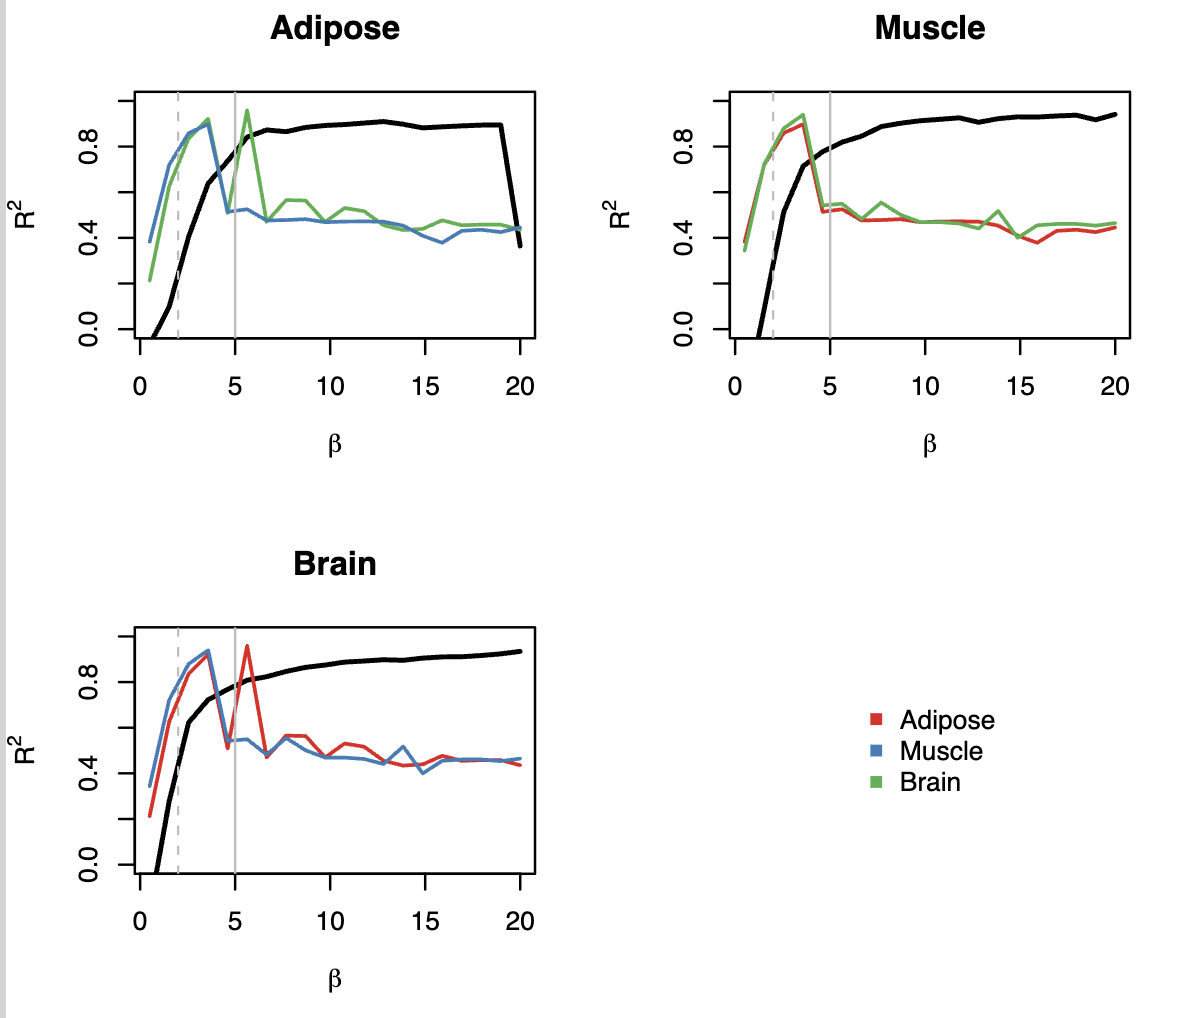

In [ ]:
plot_beta_series_pdf <- function(beta_info, tissues, out_file = "plots/beta_series.pdf",
                                 vline_TS = NULL, vline_CT = NULL,
                                 layout_rows = 4, layout_cols = 2,
                                 thr = 0.80, require_nonpos_slope = TRUE) {
  dir.create(dirname(out_file), showWarnings = FALSE, recursive = TRUE)
  cols <- .tissue_palette(tissues)

  ts_df <- beta_info$TS_fit_curves
  ct_df <- beta_info$CT_fit_curves

  crosses <- .compute_crossings_from_fit_curves(beta_info, tissues, thr, require_nonpos_slope)

  .r2_col_ts <- .get_col(ts_df, c("SFT.R.sq","Rsquared.SFT"))
  .slope_col_ts <- .get_col(ts_df, c("slope","slope.SFT"))
  .r2_col_ct <- .get_col(ct_df, c("Rsquared.SFT","SFT.R.sq"))

  pdf(out_file, height = 9, width = 5)
  on.exit(dev.off(), add = TRUE)
  par(mfrow = c(layout_rows, layout_cols))

  for (t in tissues) {
    ts_t <- if (!is.null(ts_df) && nrow(ts_df)) ts_df[ts_df$tissue == t, , drop = FALSE] else ts_df[0,]
    if (!nrow(ts_t)) { plot.new(); title(t); next }

    plot(ts_t$Power, ts_t[[.r2_col_ts]], type = "l", lwd = 2, col = "black",
         ylim = c(0, 1), main = t,
         xlab = expression(beta), ylab = expression(R^2))
    points(ts_t$Power, ts_t[[.r2_col_ts]], pch = 16, cex = 0.8, col = "black")

    if (!is.null(ct_df) && nrow(ct_df)) {
      keep <- grepl(paste0("^", t, "\\|\\|"), ct_df$pair) | grepl(paste0("\\|\\|", t, "$"), ct_df$pair)
      ct_sub <- ct_df[keep, , drop = FALSE]
      if (nrow(ct_sub)) {
        partners <- vapply(ct_sub$pair, function(p) {
          ab <- strsplit(p, "\\|\\|")[[1]]; if (ab[1] == t) ab[2] else ab[1]
        }, character(1))
        split_list <- split(ct_sub, partners)
        for (p in names(split_list)) {
          df <- split_list[[p]]
          lines(df$Power, df[[.r2_col_ct]], col = cols[[p]], lwd = 1.5)
          points(df$Power, df[[.r2_col_ct]], col = cols[[p]], pch = 16, cex = 0.6)
        }
      }
    }

    abline(h = thr, col = "grey70", lty = 3)

    b_ts <- crosses$TS[[t]]
    if (is.finite(b_ts)) abline(v = b_ts, col = "black", lty = 2, lwd = 1.5)

    if (!is.null(ct_df) && nrow(ct_df)) {
      partners_all <- unique(unlist(strsplit(names(crosses$CT), "\\|\\|")))
      partners_all <- setdiff(partners_all, NA_character_)
      for (p in setdiff(partners_all, t)) {
        nm1 <- paste0(t, "||", p); nm2 <- paste0(p, "||", t)
        b_ct <- if (!is.na(crosses$CT[nm1])) crosses$CT[nm1] else crosses$CT[nm2]
        if (is.finite(b_ct)) abline(v = b_ct, col = cols[[p]], lty = 2, lwd = 1.2)
      }
    }
  }

  plot(0, 0, type = "n", axes = FALSE, xlab = "", ylab = "")
  legend("center", legend = tissues, col = cols[tissues], pch = 15, cex = 0.95, ncol = 2, bty = "n")
}

plot_tissue_summaries_pdf <- function(beta_info, tissues,
                                      out_file = "plots/beta_series_tissue_summaries.pdf") {
  dir.create(dirname(out_file), showWarnings = FALSE, recursive = TRUE)
  cols <- .tissue_palette(tissues)
  ts_df <- beta_info$TS_fit_curves
  if (is.null(ts_df) || !nrow(ts_df)) {
    warning("TS_fit_curves is empty; skipping summaries plot.")
    return(invisible(NULL))
  }

  ts_df$signed_R2 <- .signed_R2_TS(ts_df)
  slope_col <- if ("slope" %in% names(ts_df)) "slope" else if ("slope.SFT" %in% names(ts_df)) "slope.SFT" else NA
  meank_col <- if ("mean.k" %in% names(ts_df)) "mean.k" else if ("mean.k." %in% names(ts_df)) "mean.k." else NA

  pdf(out_file, height = 16, width = 5)
  on.exit(dev.off(), add = TRUE)
  par(mfrow = c(4,1))

  yr <- range(ts_df$signed_R2, na.rm = TRUE)
  i <- 1
  ts_t <- ts_df[ts_df$tissue == tissues[i], ]
  plot(ts_t$Power, ts_t$signed_R2, type = "b", pch = 16, col = cols[[tissues[i]]],
       ylim = yr, xlab = expression(beta), ylab = expression(R^2))
  if (length(tissues) > 1) {
    for (i in 2:length(tissues)) {
      ts_t <- ts_df[ts_df$tissue == tissues[i], ]
      points(ts_t$Power, ts_t$signed_R2, type = "b", pch = 16, col = cols[[tissues[i]]])
    }
  }

  if (!is.na(slope_col)) {
    yr <- range(ts_df[[slope_col]], -1, na.rm = TRUE)
    i <- 1
    ts_t <- ts_df[ts_df$tissue == tissues[i], ]
    plot(ts_t$Power, ts_t[[slope_col]], type = "b", pch = 16, col = cols[[tissues[i]]],
         ylim = yr, xlab = expression(beta), ylab = "Slope")
    if (length(tissues) > 1) {
      for (i in 2:length(tissues)) {
        ts_t <- ts_df[ts_df$tissue == tissues[i], ]
        points(ts_t$Power, ts_t[[slope_col]], type = "b", pch = 16, col = cols[[tissues[i]]])
      }
    }
  } else {
    plot.new(); title("Slope (missing in TS_fit_curves)")
  }

  if (!is.na(meank_col)) {
    yr <- range(ts_df[[meank_col]], na.rm = TRUE)
    i <- 1
    ts_t <- ts_df[ts_df$tissue == tissues[i], ]
    plot(ts_t$Power, ts_t[[meank_col]], type = "b", pch = 16, col = cols[[tissues[i]]],
         ylim = yr, xlab = expression(beta), ylab = "Mean connectivity")
    if (length(tissues) > 1) {
      for (i in 2:length(tissues)) {
        ts_t <- ts_df[ts_df$tissue == tissues[i], ]
        points(ts_t$Power, ts_t[[meank_col]], type = "b", pch = 16, col = cols[[tissues[i]]])
      }
    }
    yr <- range(log10(ts_df[[meank_col]]), na.rm = TRUE)
    i <- 1
    ts_t <- ts_df[ts_df$tissue == tissues[i], ]
    plot(ts_t$Power, log10(ts_t[[meank_col]]), type = "b", pch = 16, col = cols[[tissues[i]]],
         ylim = yr, xlab = expression(beta), ylab = "Mean connectivity (log10)")
    if (length(tissues) > 1) {
      for (i in 2:length(tissues)) {
        ts_t <- ts_df[ts_df$tissue == tissues[i], ]
        points(ts_t$Power, log10(ts_t[[meank_col]]), type = "b", pch = 16, col = cols[[tissues[i]]])
      }
    }
  } else {
    plot.new(); title("Mean connectivity (missing)"); plot.new(); title("Mean connectivity (log10) (missing)")
  }

  legend("topright", legend = tissues, col = cols[tissues], pch = 16, cex = 1.0, bty = "n")
}

build_beta_matrix <- function(beta_info, tissues) {
  B <- matrix(NA_real_, nrow = length(tissues), ncol = length(tissues),
              dimnames = list(tissues, tissues))
  ts_map <- beta_info$TS_power_map
  if (is.null(ts_map) || all(is.na(ts_map))) {
    diag(B) <- beta_info$TS_power
  } else {
    for (t in tissues) B[t, t] <- as.numeric(ts_map[[t]])
  }
  ct_map <- beta_info$CT_power_map
  if (!is.null(ct_map) && length(ct_map)) {
    for (nm in names(ct_map)) {
      ab <- .split_pair(nm)[[1]]
      if (length(ab) != 2) next
      a <- ab[1]; b <- ab[2]
      if (a %in% tissues && b %in% tissues) {
        B[a, b] <- as.numeric(ct_map[[nm]])
        B[b, a] <- as.numeric(ct_map[[nm]])
      }
    }
  } else {
    for (i in seq_along(tissues)) for (j in seq_along(tissues)) if (i != j) B[i,j] <- beta_info$CT_power
  }
  B
}

plot_beta_matrix_heatmap <- function(beta_info, tissues,
                                     out_pdf = "plots/betas_heatmap.pdf",
                                     out_csv = "output/beta_matrix.csv",
                                     thr = 0.8, require_nonpos_slope = TRUE,
                                     palette_fun = function() grDevices::colorRampPalette(rev(RColorBrewer::brewer.pal(9, "Spectral")))(21)) {
  .require_or_stop(c("gplots", "RColorBrewer"))
  dir.create(dirname(out_pdf), showWarnings = FALSE, recursive = TRUE)
  dir.create(dirname(out_csv), showWarnings = FALSE, recursive = TRUE)

  B <- build_beta_matrix_from_crossings(beta_info, tissues, thr = thr, require_nonpos_slope = require_nonpos_slope)
  if (!any(is.finite(B))) stop("All entries in beta matrix are NA.")
  B_imp <- B
  med <- stats::median(B[is.finite(B)], na.rm = TRUE)
  B_imp[!is.finite(B_imp)] <- med  
  rowv <- as.dendrogram(hclust(dist(B_imp), method = "average"))
  colv <- as.dendrogram(hclust(dist(t(B_imp)), method = "average"))

  pdf(out_pdf, width = 10, height = 8)
  on.exit(dev.off(), add = TRUE)
  gplots::heatmap.2(
    B,
    Rowv = rowv, Colv = colv, trace = "none",
    col = palette_fun(), cellnote = ifelse(is.finite(B), round(B, 2), NA),
    notecol = "black", margins = c(12, 14), key = TRUE, density.info = "none",
    main = bquote("First " * beta * " crossing (R"^2 * " ≥ " * .(thr) * ", slope ≤ 0)"),
    cexRow = 1.0, cexCol = 1.0, srtCol = 45, na.color = "white"
  )
  dev.flush()

  ggsave(out_pdf, width = 10, height = 8)

  write.csv(B, file = out_csv, row.names = TRUE)
  invisible(list(mat = B, pdf = out_pdf, csv = out_csv))

}

make_all_beta_plots <- function(beta_info, tissues,
                                out_prefix = "xwgcna",
                                series_pdf = file.path("plots", paste0(out_prefix, "_beta_series.pdf")),
                                summaries_pdf = file.path("plots", paste0(out_prefix, "_beta_series_tissue_summaries.pdf")),
                                heatmap_pdf = file.path("plots", paste0(out_prefix, "_betas_heatmap.pdf")),
                                heatmap_csv = file.path("output", paste0(out_prefix, "_beta_matrix.csv")),
                                thr = 0.80) {
  plot_beta_series_pdf(beta_info, tissues, out_file = series_pdf, thr = thr, require_nonpos_slope = TRUE)

  plot_tissue_summaries_pdf(beta_info, tissues, out_file = summaries_pdf)

  plot_beta_matrix_heatmap(beta_info, tissues,
                           out_pdf = heatmap_pdf, out_csv = heatmap_csv,
                           thr = thr, require_nonpos_slope = TRUE)

  message("✓ Plots written:\n  - ", series_pdf,
          "\n  - ", summaries_pdf,
          "\n  - ", heatmap_pdf,
          "\n✓ Beta matrix CSV: ", heatmap_csv)
}